# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [66]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot
from gensim.models import Word2Vec

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [3]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [4]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [5]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [6]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


## 1. Familiarization

Number of nodes in the graph:  27718
Number of edges in the graph:  2014162
Average number of degrees per node:  72.67


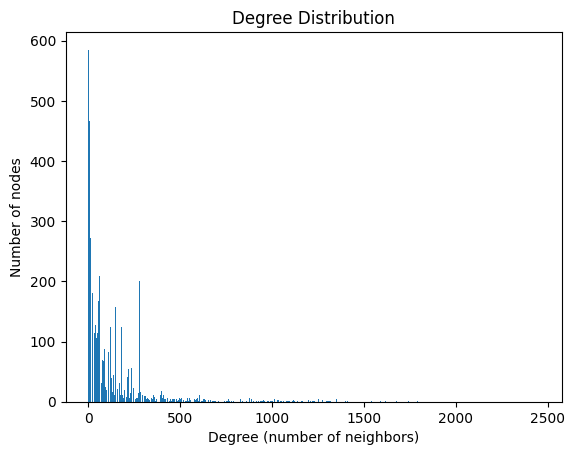

We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely 347
The node with the highest degree has 2452 neighbours. There are 2 nodes with many neighbours in the graph.


In [35]:
n = len(medium_graph.nodes)
m = len(medium_graph.edges)
print("Number of nodes in the graph: ", n)
print("Number of edges in the graph: ", m)

degree_view = medium_graph.degree
#print(degree_view)
degree_counts = {}
for _, degree in degree_view:
    if degree not in degree_counts:
        degree_counts[degree] = 1
    else:
        degree_counts[degree] += 1
#print(degree_counts)

degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

max_degree = max(degrees)

degree_dict = dict(degree_view)
number_of_isolated_nodes = list(degree_dict.values()).count(0)

degree_list = list(degree_view)
#print("degree_list", degree_list)
sorted_degree_list = sorted(degree_list, key=lambda x: x[1])

print("Average number of degrees per node: ", round(m/n, 2))

pyplot.bar(degrees, counts)
pyplot.xlabel('Degree (number of neighbors)')
pyplot.ylabel('Number of nodes')
pyplot.title('Degree Distribution')
pyplot.show()


#print("sorted list", sorted_degree_list)
print("We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely", number_of_isolated_nodes)



print("The node with the highest degree has", max_degree, "neighbours. There are", list(degree_dict.values()).count(max_degree), "nodes with many neighbours in the graph.")

## 2. Spectral node embeddings

The compute_spectral_embeddings function calculates the spectral embeddings for a connected graph.

In [37]:
def compute_spectral_embeddings(graph: nx.Graph, dim: int) -> np.ndarray:
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))

    # make sure the matrix is symmetric
    assert (adjacency_matrix == adjacency_matrix.T).all()

    degrees = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degrees)

    laplacian_matrix = degree_matrix - adjacency_matrix

    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    dim_eigenvectors = eigenvectors[:, :dim]
    result = dim_eigenvectors

    return result

Let's split the graph into all the connected components, and call the compute_spectral_embedding function for each component.

In [39]:
embeddings = []
dim = 80
for component in nx.connected_components(medium_graph):
    subgraph = medium_graph.subgraph(component)
    embeddings.append(compute_spectral_embeddings(subgraph, dim))

In [44]:
print(len(embeddings))
print(embeddings[0].shape)
for i in range(20):
    print(embeddings[i].shape)

760
(24392, 80)
(24392, 80)
(2, 2)
(2, 2)
(34, 34)
(698, 80)
(2, 2)
(14, 14)
(2, 2)
(57, 57)
(2, 2)
(1, 1)
(2, 2)
(5, 5)
(57, 57)
(11, 11)
(4, 4)
(3, 3)
(3, 3)
(3, 3)
(10, 10)


In [56]:
print(embeddings[0])

[[ 6.40289374e-03 -3.62579778e-04  8.50695370e-05 ...  6.56715996e-05
  -2.25409821e-04 -5.03722027e-05]
 [ 6.40289374e-03 -5.77767953e-04  8.11657452e-05 ...  1.69255839e-05
  -1.06926243e-04  7.15849070e-05]
 [ 6.40289374e-03 -5.99778130e-04  8.40876981e-05 ...  2.04945885e-05
  -1.63885707e-04  8.33310781e-05]
 ...
 [ 6.40289374e-03 -5.82750973e-04  8.17655614e-05 ...  2.15472701e-05
  -1.45042205e-04  7.26061071e-05]
 [ 6.40289374e-03 -5.97821702e-04  8.40528430e-05 ...  5.01400685e-06
  -1.46446113e-04  8.87766167e-05]
 [ 6.40289374e-03 -4.97113097e-04  8.96498173e-05 ...  9.19653568e-05
  -3.21749311e-04 -4.72274708e-05]]


We saw earlier that there are a lot of isolated nodes. The following diagram shows us the sizes of all the components. For better visualization purposes we got rid of the 2 largest components. These components had 24392 and 698 nodes.

198


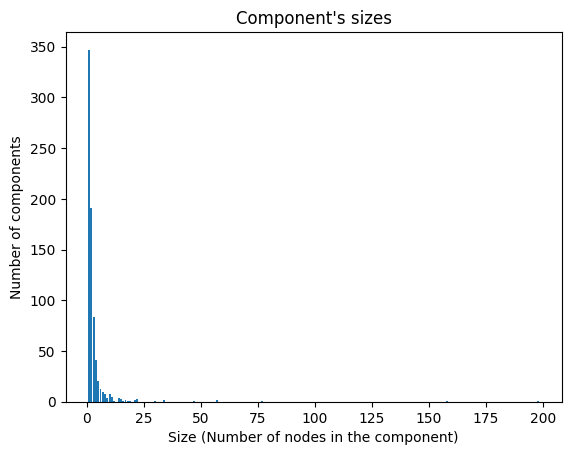

In [55]:
component_count = {}
maxi = 0
for emb in embeddings:
    size = emb.shape[0]
    if(size > 697):
        continue
    maxi = max(maxi, size)
    if size not in component_count:
        component_count[size] = 1
    else:
        component_count[size] += 1
#print(degree_counts)

print(maxi)

component_size = list(component_count.keys())
counts = list(component_count.values())

pyplot.bar(component_size, counts)
pyplot.xlabel('Size (Number of nodes in the component)')
pyplot.ylabel('Number of components')
pyplot.title('Component\'s sizes')
pyplot.show()

## 2. Random walks

When we create the random walks it is important that we handle the isolated nodes as well because our graph is disconnected. To handle them we will always make them walk back to themselves, this is a good idea here because isolated points are only similar to themselves. 

In [60]:
import random

def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    
    result = []

    for node in graph.nodes:
        for _ in range(num_walks):
            walk = [node] 
            current_node = node
            for _ in range(walk_length - 1):
                neighbors = list(graph.neighbors(current_node))
                if(len(neighbors) == 0):
                    walk.append(current_node)
                    continue
                current_node = random.choice(neighbors)
                walk.append(current_node)
            result.append(walk)

    return np.array(result)

In [61]:
num_walks = 10
walk_length = 20

walks = random_walks(medium_graph, num_walks, walk_length)

In [64]:
for i in range(10):
    print(walks[i * 10])

[    0 17751  5933 24625  2794  3920 10926 15844 22801 18639 20679  2532
  4453 14065 26035   814 13048  6956  6568 13786]
[    1  6929 17254  6438 10859  3075 27508 19692 16534 14906 22178  7607
  6564 11595  6059  2275  2400 19328   132 12106]
[    2  4544 22377  9842  6873 11570 16142 10165  9537  4585  8982 25769
 24520  8432  8159 26472  3360  1376 12708  8954]
[    3 14570 11622 23332  9614  5923  4059  8751 15544 21787 11535  2352
  4851  9979 11236 12012 10234 25001  4941 27642]
[    4 21496  8559  6155 13938 18722 23408 23265 14044 11595 22764  6670
 11308 17935  2677 11416 10767  1971 25737 15873]
[    5  4770  6816 11571 17490 20426  1115 16956  5341   991  6717 12492
   577 18087  1750  4521 19937 17776 21826  6204]
[    6 17525 26914 25490 11092  2407  9086  1297 24585 27667 16791 15701
  2253 10477 19872 21938  5925 13576 11662 12533]
[    7 20900 24515 18244 18920   340  6521 18922 25477  9778  6083 10115
  8459  7536 24544 16046 13065 19946 10923  2585]
[    8  9213 276

Now let's use this function to compute node embeddings. 

In [67]:
def compute_node_embeddings(graph: nx.Graph, num_walks: int, walk_length: int, embedding_dim: int) -> Word2Vec:
    
    walks = random_walks(graph, num_walks, walk_length)
    
    # Convert node IDs to strings (Word2Vec expects strings)
    walks = [[str(node) for node in walk] for walk in walks]
    
    # Train Word2Vec model
    model = Word2Vec(
        sentences=walks,
        vector_size=embedding_dim,
        window=5,  # Context window size
        min_count=1,  # Minimum frequency for a node to be considered
        sg=1,  # Use Skip-Gram (sg=1), CBOW (sg=0)
        workers=4,  # Number of parallel threads
        epochs=10  # Number of training epochs
    )
    
    return model

In [69]:
num_walks = 10
walk_length = 20
embedding_dim = 100

node2vec_model = compute_node_embeddings(medium_graph, num_walks, walk_length, embedding_dim)


In [72]:
node_id = "0"  # Node IDs are strings in the Word2Vec model
embedding = node2vec_model.wv[node_id]
print(f"Embedding for node {node_id}: {embedding}")

Embedding for node 0: [ 0.720558    0.06132406  0.82884246 -0.02702138 -0.9071063  -0.1591465
  0.24873692 -0.22982225  0.11668132 -0.475037    0.5993882   0.36262864
 -0.6143764  -0.8156927  -0.49240956  0.01359655  0.23887137  0.18830572
  0.14841413  1.1874446  -0.5297572  -0.17677344  0.26196072  0.39546108
 -0.17553087 -0.6079041   0.9104196   0.5858359   0.21305752 -0.31291106
 -0.1700227   0.04389351 -0.4605348  -0.76104677 -0.18900801 -0.20929924
 -0.20290558 -0.0047121   0.7047933  -0.31758094  0.01483754 -0.21472493
 -0.3091049   0.47362423  0.11125015 -0.38476926 -0.5637623  -0.03096904
  0.5922336   0.26220468 -0.58955085  0.44977775  0.16743231 -0.14689639
 -0.04507628  0.64834255 -0.30490515 -0.08045828  1.3372009  -0.32930836
 -0.17708847 -0.23156866  0.3332721  -0.28626457  0.28912255  0.6859924
  0.22341171  0.41567075  0.41284102 -0.22365235  0.0521722  -0.54026324
  0.5631951  -0.14083795 -0.8307308   0.24454671 -0.30735475  0.09208219
 -0.02736627  0.12456422 -0.101